In [104]:
# Analyse tournament results
import os 
import sys
import pandas as pd
import requests
import glob
import json

# Build the path to the pdb files
file_dir = os.getcwd()
folder_name = file_dir.split('/')[-1]
repo_dir = file_dir.replace(f'/{folder_name}', '')
plot_dir = f'{file_dir}/plots'
os.makedirs(plot_dir, exist_ok=True)
pdb_dir = f"{repo_dir}/tournament_benchmark/gpcr_tournament"
principal_agonists_df = pd.read_csv(f"{repo_dir}/classifier_benchmark_data/output/6_interactions_with_decoys.csv")
principal_agonists_df = principal_agonists_df[principal_agonists_df["Decoy Type"] == "Principal Agonist"]

chosen_grn_path = f"{repo_dir}/grn_analysis/chosen_grns.txt"
with open(chosen_grn_path) as f:
    chosen_grns = f.readlines()
    chosen_grns = [x.strip() for x in chosen_grns]
    chosen_grns = [x.replace("x", ".") for x in chosen_grns]

# Get the pdb files - list all pdb files in the pdb_dir directory and its subdirectories
pdb_files = []
for root, dirs, files in os.walk(pdb_dir):
    for file in files:
        if file.endswith(".pdb"):
            pdb_files.append(os.path.join(root, file))

# Use glob to find all matching files
pattern = os.path.join(repo_dir, "tournament_benchmark/gpcr_tournament/*/msas/chain_id_map.json")
matching_files = glob.glob(pattern)

# Print the list of matching files
for file_path in matching_files:

    # Read the chain_id_map.json file
    chain_id_map = json.load(open(file_path))
    receptor = chain_id_map["A"]["description"]
    principal_agonist = principal_agonists_df[principal_agonists_df["Target ID"] == receptor]["Decoy ID"].values[0]

    ligand_chain = "None"
    for key in chain_id_map:
        if str(chain_id_map[key]["description"]) == str(principal_agonist):
            ligand_chain = key
    
    # Set the column value in principal_agonists_df to the ligand chain
    principal_agonists_df.loc[principal_agonists_df["Target ID"] == receptor, "Ligand Chain"] = ligand_chain

In [105]:
'''
Script to check whether a predicted receptor-ligand complex includes interactions between the ligand and the receptor.
The interactions will only focus on the generic residue numbers that are observed in the dataset of stucturally resolved complexes of 
GPCRs and endogenous peptide ligands or their non-endogenous analogues.
'''

import subprocess 
import os
from Bio.PDB.NeighborSearch import NeighborSearch
import pandas as pd
import glob
import csv 
import json

def get_chains_from_pdb(pdb_path, chain_to_get, output_path):
    """
    Helper function to get specific chains from a pdb file
    Note: requires pdb-tools to be installed using: pip install pdb-tools
    """
    chain_to_get = ",".join(chain_to_get)

    # Command to run on terminal - uses pdb-tools pdb_selchain to extract receptor and peptide chain from PDB file
    command = f"pdb_selchain -{chain_to_get} {pdb_path} > {output_path}"

    # Run command on terminal
    os.system(command)

    return output_path

def apply_generic_numbering(pdb_path, output_path, chain_to_get="B"):
    '''
    Function to apply generic numbering to a PDB file of a receptor. 
    '''
    # Apply generic numbering to the pdb file
    command = f'curl -X POST -F "pdb_file=@{pdb_path}" https://gpcrdb.org/services/structure/assign_generic_numbers'
    output = subprocess.check_output(command, shell=True)
    # Make sure output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with open(output_path, 'wb') as f:
        f.write(output)

    # Compare lines in the input pdb and the output pdb 
    # and empty b-factor field in the output pdb so that only GRN
    # is stored in the b-factor field
    with open(pdb_path, 'r') as f:
        pdb = f.readlines()
        pdb = [line.strip() for line in pdb]
        pdb = [line for line in pdb if line.startswith("ATOM")]
        pdb = [line for line in pdb if line[21] == chain_to_get]
        
    with open(output_path, 'r') as f:
        output_pdb = f.readlines()
        output_pdb = [line.strip() for line in output_pdb]     
        output_pdb = [line for line in output_pdb if line.startswith("ATOM")] 
        output_pdb = [line for line in output_pdb if line[21] == chain_to_get]

    # Make a dictionary from residue number to generic residue number
    grn_dict = {}
    for i in range(len(pdb)):
        if pdb[i] != output_pdb[i]:
            residue_number = pdb[i][22:26].strip()
            generic_number = output_pdb[i][60:66].strip()
            grn_dict[residue_number] = generic_number
        else:
            # Replace the b-factor field with empty space
            output_pdb[i] = output_pdb[i][:60] + "     0" + output_pdb[i][66:]

    # Save the dictionary into a json file
    grn_json_path = output_path.replace(".pdb", ".json")
    with open(grn_json_path, 'w') as f:
        json.dump(grn_dict, f)

    # Save the pdb file with generic residue numbers
    with open(output_path, 'w') as f:
        for line in output_pdb:
            f.write(line + "\n")

    return output_path

def get_grn_positions(grn_pdb_path, receptor_chain):

    # Open grn_pdb file
    with open(grn_pdb_path, 'r') as f:
        grn_pdb = f.readlines()
        grn_pdb = [line.strip() for line in grn_pdb]

    # Get only CA atoms from the receptor chain
    ca_grn_pdb = [line for line in grn_pdb if "CA" == line[12:16].strip()]
    ca_grn_pdb = [line for line in ca_grn_pdb if line[21] == receptor_chain]

    # Make a dictionary with residue numbers as keys and generic residue numbers as values
    grn_dict = {}
    for grn_position in ca_grn_pdb:
        residue_number = grn_position[22:26].strip()
        generic_number = grn_position[60:66].strip()
        grn_dict[residue_number] = generic_number

    return grn_dict

def get_atom_list(pdb_path, grn_folder, receptor_chain = "B", ligand_chain = "C", search_radius = 6.6):

    # Open pdb using biopython
    from Bio.PDB import PDBParser
    parser = PDBParser()
    pdb_name = pdb_path.split("/")[-1].split(".")[0]
    structure = parser.get_structure(pdb_name, pdb_path)

    # Save atom objects into two lists: one for the receptor and one for the peptide
    atom_list_receptor = []
    atom_list_peptide = []
    for atom in structure.get_atoms():
        chain_id = atom.get_full_id()[2]
        if chain_id == receptor_chain:
            atom_list_receptor.append(atom)
        elif chain_id == ligand_chain:
            atom_list_peptide.append(atom)

    # Apply generic numbering to the receptor
    receptor_name = pdb_name.split("___")[0]
    grn_path = os.path.join(grn_folder, receptor_name + "_grn.pdb")
    grn_json_path = grn_path.replace(".pdb", ".json")
    if not os.path.exists(grn_path):
        apply_generic_numbering(pdb_path, grn_path)

    # Load the generic residue numbers from the json file
    with open(grn_json_path, 'r') as f:
        generic_residue_numbers = json.load(f)
     
    # Filter receptor atom list based on generic residue numbers
    grn_list_receptor = []
    for atom in atom_list_receptor:
        # Get residue number of atom
        residue_number = str(atom.get_parent().get_id()[1])
        if residue_number in generic_residue_numbers:
            grn_list_receptor.append(atom)

    # Concatenate two lists
    grn_list_receptor.extend(atom_list_peptide)

    # Get interactions between receptor and peptide
    ns = NeighborSearch(grn_list_receptor)
    all_neighbors = ns.search_all(search_radius, "R")
    all_neighbors = [pair for pair in all_neighbors if pair[0].get_full_id()[2] != pair[1].get_full_id()[2]]
    all_neighbors = sorted(all_neighbors, key=lambda x: x[0].get_full_id())
    
    # Return generic residue numbers for interacting receptor positions
    grns = []
    for pair in all_neighbors:
        res_n = pair[0].get_full_id()[-1][1]
        grns.append(generic_residue_numbers[str(res_n)])
    grns = list(set(grns))
    return sorted(grns)
    
# Path to the folder that contains the generic residue numbers for each receptor
grn_folder = f"{repo_dir}/tournament_benchmark/grn_pdbs"

# List all pdbs in pdb_directory and its subdirectories
pdb_directory = f"{repo_dir}/tournament_benchmark/gpcr_tournament"
output_csv = f"{repo_dir}/tournament_benchmark/interacting_grns.csv"

# Process each PDB file and write results to the CSV file line by line
with open(output_csv, "w", newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["pdb", "chain", "interacting_grns"])  # Write header
    c = 0
    for pdb in pdb_files:
        for chain in ["C", "D", "E", "F", "G"]:
            c+=1
            if os.path.exists(pdb):
                print(f"Processing {pdb}, {c}/{len(pdb_files)}", flush = True)
                grns = get_atom_list(pdb, grn_folder, ligand_chain = chain) 
                pdb_name = os.path.basename(pdb).split(".")[0]
                csv_writer.writerow([pdb_name, chain, grns])

interactions_df = pd.read_csv(f"{repo_dir}/tournament_benchmark/interacting_grns.csv")

Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/ackr2_tournament/ackr2_tournament.pdb, 1/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/ackr2_tournament/ackr2_tournament.pdb, 2/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/ackr2_tournament/ackr2_tournament.pdb, 3/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/ackr2_tournament/ackr2_tournament.pdb, 4/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/ackr2_tournament/ackr2_tournament.pdb, 5/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_benchmarking/tournament_benchmark/gpcr_tournament/qrfpr_tournament/qrfpr_tournament.pdb, 6/124
Processing /Users/pqh443/Documents/Git_projects/GPRC_peptide_ben

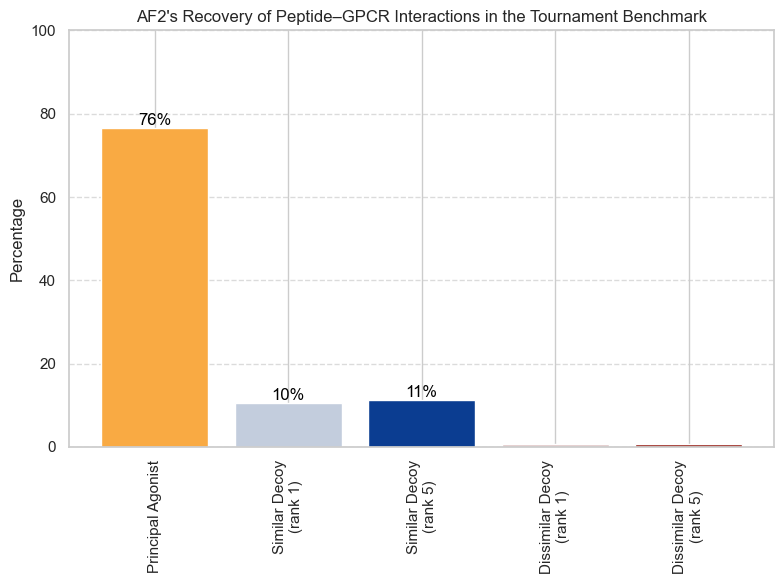

In [106]:
import ast
# Loop over interactions_df and keep only those rows that have at least 
# one generic residue number that is in chosen_grns
chosen_interactions = []
for index, row in interactions_df.iterrows():

    # Convert string back to list
    interacting_grns = ast.literal_eval(row["interacting_grns"])

    # Check if any of the interacting grns are in chosen_grns,
    # if so, keep the row, otherwise discard it
    c = 0
    results = list(row)
    interacting_pocket_grns = []
    for grn in interacting_grns:
        if grn in chosen_grns:
            interacting_pocket_grns.append(grn)
            c +=1

    results.append(interacting_pocket_grns)
    results.append(c)
    chosen_interactions.append(results)

chosen_interactions = pd.DataFrame(chosen_interactions, columns=["pdb", "chain", "interacting_grns", "interacting_pocket_grns", "num_interactions"])

# Sort the data frame first based on pdb, then by num_interactions descending
chosen_interactions = chosen_interactions.sort_values(by=["pdb", "num_interactions"], ascending=[True, False])
chosen_interactions = chosen_interactions.groupby("pdb").first().reset_index()

# Print value counts of chains
plot_data = chosen_interactions["chain"].value_counts()
plot_data = plot_data.reset_index()
plot_data.columns = ["Chain", "Count"]
plot_data["Percentage"] = plot_data["Count"] / plot_data["Count"].sum() * 100

# Rename the chains
plot_data["Chain"] = plot_data["Chain"].replace("C", "Principal Agonist")
plot_data["Chain"] = plot_data["Chain"].replace("D", "Similar Decoy\n(rank 1)")
plot_data["Chain"] = plot_data["Chain"].replace("E", "Similar Decoy\n(rank 5)")
plot_data["Chain"] = plot_data["Chain"].replace("F", "Dissimilar Decoy\n(rank 1)")
plot_data["Chain"] = plot_data["Chain"].replace("G", "Dissimilar Decoy\n(rank 5)")

import matplotlib.pyplot as plt

sys.path.append(repo_dir)
from colors import COLOR

colors = [COLOR["Principal Agonist"], COLOR["Similar0"], COLOR["Similar4"], COLOR["Dissimilar0"], COLOR["Dissimilar4"]]

# Reorder data based on the desired sequence
ordered_data = plot_data.set_index('Chain').loc[
    ['Principal Agonist', 'Similar Decoy\n(rank 1)', 'Similar Decoy\n(rank 5)', 'Dissimilar Decoy\n(rank 1)', 'Dissimilar Decoy\n(rank 5)']
].reset_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(ordered_data['Chain'], ordered_data['Percentage'], color=colors)

# Adding text labels to bars with counts higher than 10
for bar in bars:
    height = bar.get_height()
    if height > 10:
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}%', ha='center', va='bottom', fontsize=12, color='black')

plt.title("AF2's Recovery of Peptide–GPCR Interactions in the Tournament Benchmark")
plt.xlabel('')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.savefig(f"{plot_dir}/interactions_recovery.png")

In [112]:
chosen_interactions["protein"] = chosen_interactions["pdb"].str.replace("_tournament", "_human")
chosen_interactions

,pdb,chain,interacting_grns,interacting_pocket_grns,num_interactions,protein
0,ackr1_tournament,E,"['1.29', '1.30', '1.32', '1.33', '45.51', '45....","[1.32, 45.51, 45.52, 7.34]",4,ackr1_human
1,ackr2_tournament,C,"['1.24', '1.25', '1.27', '1.28', '1.35', '1.39...","[3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7.38]",7,ackr2_human
2,ackr3_tournament,C,"['1.39', '2.59', '2.60', '2.63', '2.64', '23.4...","[3.32, 4.61, 45.51, 45.52, 7.34, 7.38]",6,ackr3_human
3,ackr4_tournament,C,"['1.27', '1.28', '1.35', '1.39', '2.60', '2.63...","[3.32, 45.51, 45.52, 7.34, 7.38]",5,ackr4_human
4,acthr_tournament,D,"['1.36', '2.56', '2.57', '2.60', '2.61', '2.63...","[3.32, 4.61, 6.55, 7.34]",4,acthr_human
...,...,...,...,...,...,...
119,v1br_tournament,C,"['-5.46', '2.60', '2.63', '23.49', '3.29', '3....","[4.61, 45.51, 45.52, 6.55, 7.38]",5,v1br_human
120,v2r_tournament,E,"['1.28', '1.29', '1.31', '1.32', '1.33', '1.34...","[1.32, 3.32, 4.61, 45.51, 45.52, 6.55, 7.34, 7...",8,v2r_human
121,vipr1_tournament,C,"['1.26', '1.27', '1.28', '1.29', '1.30', '1.31...","[1.32, 45.52, 7.34, 7.38]",4,vipr1_human
122,vipr2_tournament,C,"['1.26', '1.27', '1.29', '1.30', '1.32', '1.33...","[1.32, 45.52, 7.34, 7.38]",4,vipr2_human


In [115]:
# Check which receptors have been structurally studied 
url = "https://gpcrdb.org/services/structure/"
response = requests.get(url)
data = response.json()
data = pd.DataFrame(data)

# Find out which "protein" entries in chosen_interactions are in data
chosen_interactions["structurally_studied"] = chosen_interactions["protein"].isin(data["protein"])
chosen_interactions[chosen_interactions["chain"] == "C"]["structurally_studied"].value_counts() 

structurally_studied
True     57
False    38
Name: count, dtype: int64